In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, f1_score)
from sklearn.model_selection import (StratifiedKFold, permutation_test_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


In [2]:
data = pd.read_csv('cancer.csv')
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,13.17,18.22,84.28,537.3,0.07466,0.05994,0.04859,0.02870,0.1454,0.05549,...,14.90,23.89,95.10,687.6,0.1282,0.1965,0.18760,0.10450,0.2235,0.06925
565,10.26,14.71,66.20,321.6,0.09882,0.09159,0.03581,0.02037,0.1633,0.07005,...,10.88,19.48,70.89,357.1,0.1360,0.1636,0.07162,0.04074,0.2434,0.08488
566,15.28,22.41,98.92,710.6,0.09057,0.10520,0.05375,0.03263,0.1727,0.06317,...,17.80,28.03,113.80,973.1,0.1301,0.3299,0.36300,0.12260,0.3175,0.09772
567,14.53,13.98,93.86,644.2,0.10990,0.09242,0.06895,0.06495,0.1650,0.06121,...,15.80,16.93,103.10,749.9,0.1347,0.1478,0.13730,0.10690,0.2606,0.07810


In [3]:
data.isna().sum()
X.isna().sum()

radius_mean          0
texture_mean         0
perimeter_mean       0
area_mean            0
smoothness_mean      0
compactness_mean     0
concavity_mean       0
points_mean          0
symmetry_mean        0
dimension_mean       0
radius_se            0
texture_se           0
perimeter_se         0
area_se              0
smoothness_se        0
compactness_se       0
concavity_se         0
points_se            0
symmetry_se          0
dimension_se         0
radius_worst         0
texture_worst        0
perimeter_worst      0
area_worst           0
smoothness_worst     0
compactness_worst    0
concavity_worst      0
points_worst         0
symmetry_worst       0
dimension_worst      0
dtype: int64

In [4]:
# check the balanlcing in label...its unbalanced..candidate for stratified split
print(y.value_counts())

B    357
M    212
Name: diagnosis, dtype: int64


In [5]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [6]:
# high correlation amongst ~12=~15 features
df_corr = X.corr()
df_corr = df_corr[df_corr > 0.6].dropna(axis=0, thresh = 10)
df_corr = df_corr[df_corr > 0.6].dropna(axis=1, thresh = 7)
df_corr

,radius_mean,perimeter_mean,area_mean,concavity_mean,points_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst,points_worst
radius_mean,1.000000,0.997855,0.987357,0.676764,0.822529,0.679090,0.674172,0.735864,0.969539,0.965137,0.941082,0.744214
perimeter_mean,0.997855,1.000000,0.986507,0.716136,0.850977,0.691765,0.693135,0.744983,0.969476,0.970387,0.941550,0.771241
area_mean,0.987357,0.986507,1.000000,0.685983,0.823269,0.732562,0.726628,0.800086,0.962746,0.959120,0.959213,0.722017
compactness_mean,NaN,NaN,NaN,0.883121,0.831135,NaN,NaN,NaN,NaN,NaN,NaN,0.815573
concavity_mean,0.676764,0.716136,0.685983,1.000000,0.921391,0.631925,0.660391,0.617427,0.688236,0.729565,0.675987,0.861323
points_mean,0.822529,0.850977,0.823269,0.921391,1.000000,0.698050,0.710650,0.690299,0.830318,0.855923,0.809630,0.910155
radius_se,0.679090,0.691765,0.732562,0.631925,0.698050,1.000000,0.972794,0.951830,0.715065,0.719684,0.751548,NaN
perimeter_se,0.674172,0.693135,0.726628,0.660391,0.710650,0.972794,1.000000,0.937655,0.697201,0.721031,0.730713,NaN
area_se,0.735864,0.744983,0.800086,0.617427,0.690299,0.951830,0.937655,1.000000,0.757373,0.761213,0.811408,NaN
radius_worst,0.969539,0.969476,0.962746,0.688236,0.830318,0.715065,0.697201,0.757373,1.000000,0.993708,0.984015,0.787424


***
## Feature Selection using
>## 1) RandomForestClassifier tree based feature importance and the permutation importance.
>## 2) From 1 above, on the computed important features, further selection using PCA (Feature Extraction using PCA and interpretation of PCA1 and PCA2 for feature selection)
***

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, random_state=10, test_size=0.2, stratify=y)

In [8]:
# Random Forest Importance on breast cancer 
clf_RF = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced')
clf_RF.fit(X_train, y_train)
print('Accuracy Score on test: ', clf_RF.score(X_test, y_test))
y_pred = clf_RF.predict(X_test)
print('confsion_matrix:')
df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=encoder.classes_, index=encoder.classes_)
df_conf_matrix


Accuracy Score on test:  0.9385964912280702
confsion_matrix:


,B,M
B,71,1
M,6,36


In [9]:
# importance of features
print('Feature importances for : \n', X.columns.values, ' \n are : \n', clf_RF.feature_importances_)

Feature importances for : 
 ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean' 'points_mean'
 'symmetry_mean' 'dimension_mean' 'radius_se' 'texture_se' 'perimeter_se'
 'area_se' 'smoothness_se' 'compactness_se' 'concavity_se' 'points_se'
 'symmetry_se' 'dimension_se' 'radius_worst' 'texture_worst'
 'perimeter_worst' 'area_worst' 'smoothness_worst' 'compactness_worst'
 'concavity_worst' 'points_worst' 'symmetry_worst' 'dimension_worst']  
 are : 
 [0.03216853 0.01919038 0.03830705 0.03545589 0.0073759  0.01187091
 0.05264031 0.15324361 0.00288166 0.00373341 0.01007357 0.00644847
 0.03049543 0.02505072 0.00287819 0.00481371 0.00874936 0.00576083
 0.0041944  0.00501732 0.10083123 0.01701347 0.06975939 0.09241001
 0.00910099 0.01943157 0.04198157 0.17087857 0.01036076 0.00788279]


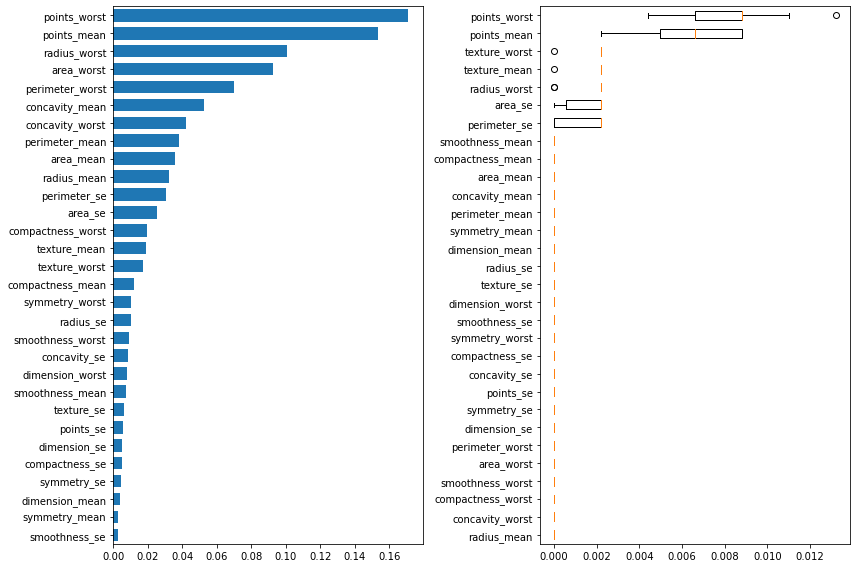

In [10]:
# we plot the tree based feature importance and the permutation importance.
result = permutation_importance(clf_RF, X_train, y_train, n_repeats=10, random_state=10)
perm_sorted_idx = result.importances_mean.argsort() # sort high to low (indexes as if array was sorted)

tree_importance_sorted_idx = np.argsort(clf_RF.feature_importances_) # sort high to low (indexes as if array was sorted)
tree_indices = np.arange(0, len(clf_RF.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf_RF.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns.values[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_RF.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns.values[perm_sorted_idx],
)
fig.tight_layout()
plt.show()


In [11]:
# handling multicollinear features
# .. high positive correlations (0 = no correlation, [+1, -1] = +ve/-ve correlation)
corr = spearmanr(X)
df_corr_spearman = pd.DataFrame(corr.correlation, columns=X.columns.values, index=X.columns.values)
print('shape of correlation: ', df_corr_spearman.shape)
df_temp = df_corr_spearman[(df_corr_spearman < -0.5) | (df_corr_spearman > 0.5)].dropna(axis=1, thresh= 10)
df_temp = df_temp[(df_temp < -0.5) | (df_temp > 0.5)].dropna(axis=0, thresh= 10)
df_temp

shape of correlation:  (30, 30)


,radius_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,points_mean,radius_se,perimeter_se,area_se,compactness_se,concavity_se,points_se,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,points_worst,dimension_worst
radius_mean,1.000000,0.997802,0.999602,NaN,0.645728,0.759702,0.550247,0.565520,0.738077,NaN,NaN,NaN,0.978604,0.971555,0.978863,NaN,0.596043,0.727265,NaN
perimeter_mean,0.997802,1.000000,0.997068,0.543925,0.681958,0.788629,0.560326,0.582789,0.745824,NaN,NaN,NaN,0.981244,0.978980,0.980864,0.534565,0.632106,0.757526,NaN
area_mean,0.999602,0.997068,1.000000,NaN,0.642557,0.755165,0.553388,0.568237,0.741518,NaN,NaN,NaN,0.979258,0.971822,0.980264,NaN,0.593736,0.723390,NaN
compactness_mean,NaN,0.543925,NaN,1.000000,0.896518,0.848295,0.506582,0.583520,0.539511,0.817875,0.772283,0.732425,0.542626,0.592254,0.531590,0.901029,0.837921,0.825473,0.688986
concavity_mean,0.645728,0.681958,0.642557,0.896518,1.000000,0.927352,0.575277,0.646199,0.644344,0.761230,0.858306,0.774656,0.682316,0.722424,0.676628,0.849985,0.938543,0.904938,0.541838
points_mean,0.759702,0.788629,0.755165,0.848295,0.927352,1.000000,0.635054,0.679841,0.726982,0.608388,0.674668,0.758438,0.787411,0.813960,0.780395,0.758309,0.827281,0.937075,NaN
radius_se,0.550247,0.560326,0.553388,0.506582,0.575277,0.635054,1.000000,0.957728,0.952867,NaN,NaN,0.595594,0.598030,0.592509,0.595732,NaN,NaN,0.508662,NaN
perimeter_se,0.565520,0.582789,0.568237,0.583520,0.646199,0.679841,0.957728,1.000000,0.926937,0.532081,0.547805,0.669574,0.606902,0.626896,0.605163,NaN,NaN,0.569428,NaN
area_se,0.738077,0.745824,0.741518,0.539511,0.644344,0.726982,0.952867,0.926937,1.000000,NaN,NaN,0.588749,0.774244,0.768336,0.775662,NaN,0.500307,0.619539,NaN
compactness_se,NaN,NaN,NaN,0.817875,0.761230,0.608388,NaN,0.532081,NaN,1.000000,0.880965,0.764150,NaN,NaN,NaN,0.789431,0.701251,0.587471,0.604844


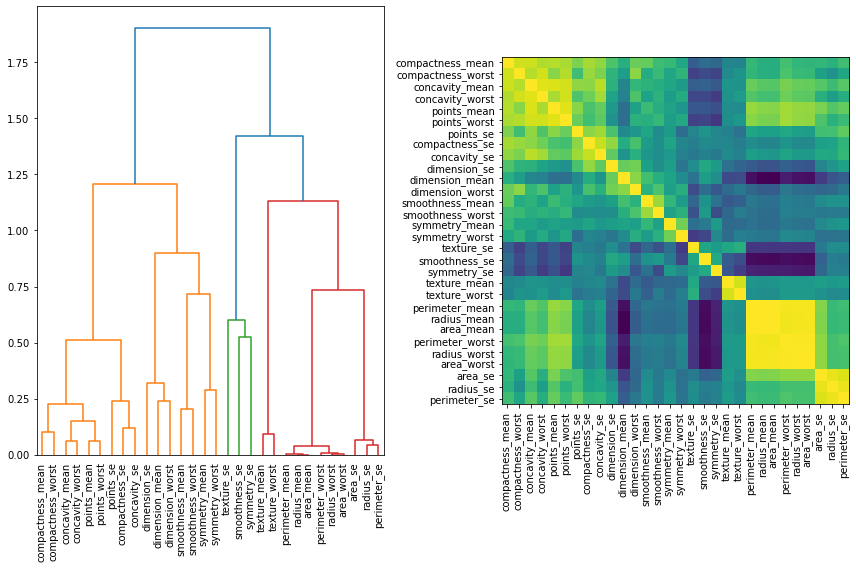

In [12]:
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
corr = (corr.correlation + corr.correlation.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.values, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))


ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

***
## Objective: dendogram represents uncorrelated features starting from top to bottom (highly uncorrelated features in top...decreasing order to bottom)
>##            As we go up, the features uncorrelated gets more prominent
>##            .e.g at 1.75, there are only 2 blue lines representing 2 most uncorrelated features
>##            .e.g at 1, there are 5 lines represent 5 most uncorrelated features

## below code sample shows the most uncorrelated features at diferent levels (1, 1.75, 1.25)
***

In [13]:
def get_features_uncorrelated(level=1):
    cluster_ids = hierarchy.fcluster(dist_linkage, level, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    return selected_features

In [14]:
uncorr_feat = X.columns.values[get_features_uncorrelated(1)]
print('Features at 1 :' , uncorr_feat)
print('Corr of feautures at 1 :')
pd.DataFrame(spearmanr(X[uncorr_feat]).correlation, columns=X[uncorr_feat].columns.values, index=X[uncorr_feat].columns.values)

Features at 1 : ['radius_mean' 'texture_mean' 'smoothness_mean' 'compactness_mean'
 'texture_se']
Corr of feautures at 1 :


,radius_mean,texture_mean,smoothness_mean,compactness_mean,texture_se
radius_mean,1.000000,0.340956,0.148510,0.497578,-0.144499
texture_mean,0.340956,1.000000,0.024649,0.266499,0.450720
smoothness_mean,0.148510,0.024649,1.000000,0.678806,0.091283
compactness_mean,0.497578,0.266499,0.678806,1.000000,0.047766
texture_se,-0.144499,0.450720,0.091283,0.047766,1.000000


In [15]:
uncorr_feat = X.columns.values[get_features_uncorrelated(1.25)]
print('Features at 1.25 :' , uncorr_feat)
print('Corr of feautures at 1.25 :')
pd.DataFrame(spearmanr(X[uncorr_feat]).correlation, columns=X[uncorr_feat].columns.values, index=X[uncorr_feat].columns.values)

Features at 1.25 : ['radius_mean' 'smoothness_mean' 'texture_se']
Corr of feautures at 1.25 :


,radius_mean,smoothness_mean,texture_se
radius_mean,1.000000,0.148510,-0.144499
smoothness_mean,0.148510,1.000000,0.091283
texture_se,-0.144499,0.091283,1.000000


In [16]:
uncorr_feat = X.columns.values[get_features_uncorrelated(1.75)]
print('Features at 1.75 :' , uncorr_feat)
print('Corr of feautures at 1.75 :')
pd.DataFrame(spearmanr(X[uncorr_feat]).correlation, columns=X[uncorr_feat].columns.values, index=X[uncorr_feat].columns.values)

Features at 1.75 : ['radius_mean' 'smoothness_mean']
Corr of feautures at 1.75 :


,radius_mean,smoothness_mean
radius_mean,0.14851,0.14851
smoothness_mean,0.14851,0.14851


***
## Proceed with features at level 1
***

In [17]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

print('Selected features from fcluster: ', X.columns.values[selected_features])

X_train_sel = pd.DataFrame(X_train[:, selected_features], columns=X.columns.values[selected_features])
X_test_sel = pd.DataFrame(X_test[:, selected_features], columns=X.columns.values[selected_features])

clf_sel = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced_subsample', ccp_alpha=0.0005)
clf_sel.fit(X_train_sel, y_train)

print(
    "Accuracy on train data with features removed: {:.2f}".format(
        clf_sel.score(X_train_sel, y_train)
    )
)

print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

print('F1_sore train dataset : ', f1_score(y_train, clf_sel.predict(X_train_sel)))
print('F1_sore test dataset : ', f1_score(y_test, clf_sel.predict(X_test_sel)))

Selected features from fcluster:  ['radius_mean' 'texture_mean' 'smoothness_mean' 'compactness_mean'
 'texture_se']
Accuracy on train data with features removed: 1.00
Accuracy on test data with features removed: 0.93
F1_sore train dataset :  1.0
F1_sore test dataset :  0.9


In [18]:
clf_DT = DecisionTreeClassifier(random_state=10, class_weight='balanced', ccp_alpha=0.0005, criterion='entropy')
clf_DT.fit(X_train_sel, y_train)
print('Train Score wth ccp_alpha (0.01055) : ', clf_DT.score(X_train_sel, y_train))
print('Test Score wth ccp_alpha (0.01055) : ', clf_DT.score(X_test_sel, y_test))
print('F1_sore train dataset : ', f1_score(y_train, clf_DT.predict(X_train_sel)))
print('F1_sore test dataset : ', f1_score(y_test, clf_DT.predict(X_test_sel)))
 

Train Score wth ccp_alpha (0.01055) :  1.0
Test Score wth ccp_alpha (0.01055) :  0.9122807017543859
F1_sore train dataset :  1.0
F1_sore test dataset :  0.8780487804878048


***
## Selected top features so far : ['radius_mean' 'texture_mean' 'smoothness_mean' 'compactness_mean' 'texture_se']
## Continue model building with only these features 
***

***
## Train accuracy vs Test accuracy seems overfitting
## Prepruning to reduce overfit on the selected_features using DT
***

In [19]:
clf_DT = DecisionTreeClassifier(random_state=10, class_weight='balanced')
path = clf_DT.cost_complexity_pruning_path(X_train_sel, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha, class_weight='balanced')
    clf.fit(X_train_sel, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.26977840874218895


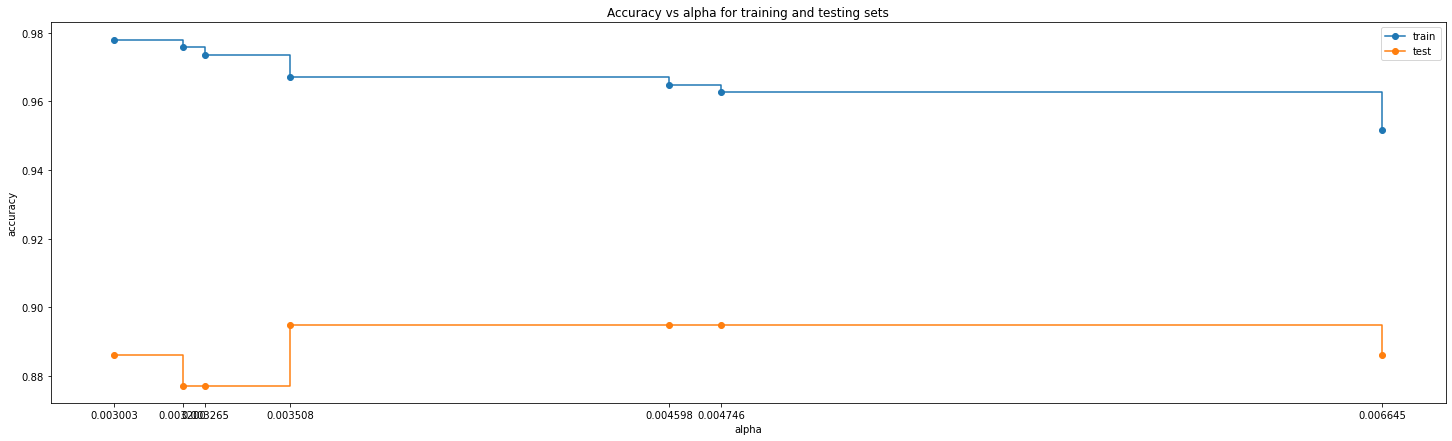

In [20]:
# dropping the last ccp_alpha scores since its with only root node and no leaves
train_scores =[clf.score(X_train_sel, y_train) for clf in clfs]
test_scores = [clf.score(X_test_sel, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize = (25, 7))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[10:-8], train_scores[10:-8], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[10:-8], test_scores[10:-8], marker="o", label="test", drawstyle="steps-post")
ax.set_xticks(ccp_alphas[10:-8])
ax.legend()
plt.show()

***
## At ccp_alpha in range [0.0035 , 0.0060], test_accuracy is max
## choosing ccp_alpha as 0.0060 in above range where train accuracy and test accuracy values are closest to reduce overfit
***

In [21]:
ccp_alpha = 0.0060
clf_DT = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha, class_weight='balanced')
clf_DT.fit(X_train_sel, y_train)
print('Train Score wth ccp_alpha (0.01055) : ', clf_DT.score(X_train_sel, y_train))
print('Test Score wth ccp_alpha (0.01055) : ', clf_DT.score(X_test_sel, y_test))
print('F1_sore train dataset : ', f1_score(y_train, clf_DT.predict(X_train_sel)))
print('F1_sore test dataset : ', f1_score(y_test, clf_DT.predict(X_test_sel)))

Train Score wth ccp_alpha (0.01055) :  0.9626373626373627
Test Score wth ccp_alpha (0.01055) :  0.8947368421052632
F1_sore train dataset :  0.9512893982808024
F1_sore test dataset :  0.8604651162790699


In [22]:
clf_sel = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced_subsample', ccp_alpha=ccp_alpha)
clf_sel.fit(X_train_sel, y_train)

print(
    "Accuracy on train data with selected_features and ccp_alpha: {:.2f}".format(
        clf_sel.score(X_train_sel, y_train)
    )
)

print(
    "Accuracy on test data with selected_features and ccp_alpha: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

print('F1_sore train dataset : ', f1_score(y_train, clf_sel.predict(X_train_sel)))
print('F1_sore test dataset : ', f1_score(y_test, clf_sel.predict(X_test_sel)))

Accuracy on train data with selected_features and ccp_alpha: 0.98
Accuracy on test data with selected_features and ccp_alpha: 0.95
F1_sore train dataset :  0.9707602339181286
F1_sore test dataset :  0.9285714285714286


***
## With ccp_alpha computed from DT and supplying in RT increased accuracy from 0.93 to 0.95 and also reduced overfit (train is 0.98...previously 1)
***

***
## Feature Selection: Find out the top 2 features from selected_features using PCA
***

In [23]:
pca = PCA(X_train_sel.shape[1])
pca.fit(X_train_sel)
print('PCA explained variance ratio :', pca.explained_variance_ratio_)

# take top 2 features from PCA1
PC1 = pca.components_[0]
idx = np.argsort(PC1)
top2_features_PC1 = X_train_sel.columns[idx][::-1][:2]
print('Top 2 features from PC1 : ', top2_features_PC1)

# take top 2 features from PCA2
PC2 = pca.components_[1]
idx = np.argsort(PC2)
top2_features_PC2 = X_train_sel.columns[idx][::-1][:2]
print('Top 2 features from PC2 : ', top2_features_PC2)


PCA explained variance ratio : [6.94065950e-01 2.97881807e-01 7.98349582e-03 6.57866143e-05
 2.96082516e-06]
Top 2 features from PC1 :  Index(['texture_mean', 'radius_mean'], dtype='object')
Top 2 features from PC2 :  Index(['radius_mean', 'compactness_mean'], dtype='object')


In [24]:
X_train_sel_pca1 = X_train_sel[top2_features_PC1]
X_test_sel_pca1 = X_test_sel[top2_features_PC1]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced_subsample', ccp_alpha=ccp_alpha)
clf_sel.fit(X_train_sel_pca1, y_train)

print(
    "Accuracy on train data with features removed: {:.2f}".format(
        clf_sel.score(X_train_sel_pca1, y_train)
    )
)

print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel_pca1, y_test)
    )
)


print('F1_sore PC1 train dataset : ', f1_score(y_train, clf_sel.predict(X_train_sel_pca1)))
print('F1_sore PC2 test dataset : ', f1_score(y_test, clf_sel.predict(X_test_sel_pca1)))

Accuracy on train data with features removed: 0.91
Accuracy on test data with features removed: 0.89
F1_sore PC1 train dataset :  0.8842729970326411
F1_sore PC2 test dataset :  0.8433734939759037


In [25]:
X_train_sel_pca2 = X_train_sel[top2_features_PC2]
X_test_sel_pca2 = X_test_sel[top2_features_PC2]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced_subsample', ccp_alpha=ccp_alpha)
clf_sel.fit(X_train_sel_pca2, y_train)

print(
    "Accuracy on train data with top2 PC2 features: {:.2f}".format(
        clf_sel.score(X_train_sel_pca2, y_train)
    )
)

print(
    "Accuracy on test data with top2 PC2 features: {:.2f}".format(
        clf_sel.score(X_test_sel_pca2, y_test)
    )
)

print('F1_sore PC2 train dataset : ', f1_score(y_train, clf_sel.predict(X_train_sel_pca2)))
print('F1_sore PC2 test dataset : ', f1_score(y_test, clf_sel.predict(X_test_sel_pca2)))


Accuracy on train data with top2 PC2 features: 0.93
Accuracy on test data with top2 PC2 features: 0.92
F1_sore PC2 train dataset :  0.9011627906976744
F1_sore PC2 test dataset :  0.8941176470588236


***
## For SL(significance level) = 0.15, CL(confidence level) = 0.85, 
## Data is unbalanced (y label does not have equal number of class), No domain knowlege, we depend on F1 score
## Both F1 results of PC1 and PC2 are satisfying (PC1 apprx of 0.8433 on test as against 0.85)
## PC2 F1 scores are more aligned towards a generalized approach (xtest ~> xtrain and xtest > cl) considering overfit and underfit
## Choosing PC2 features over PC1 features
***

***
## Plot decision regions using SVC and check predictions
***

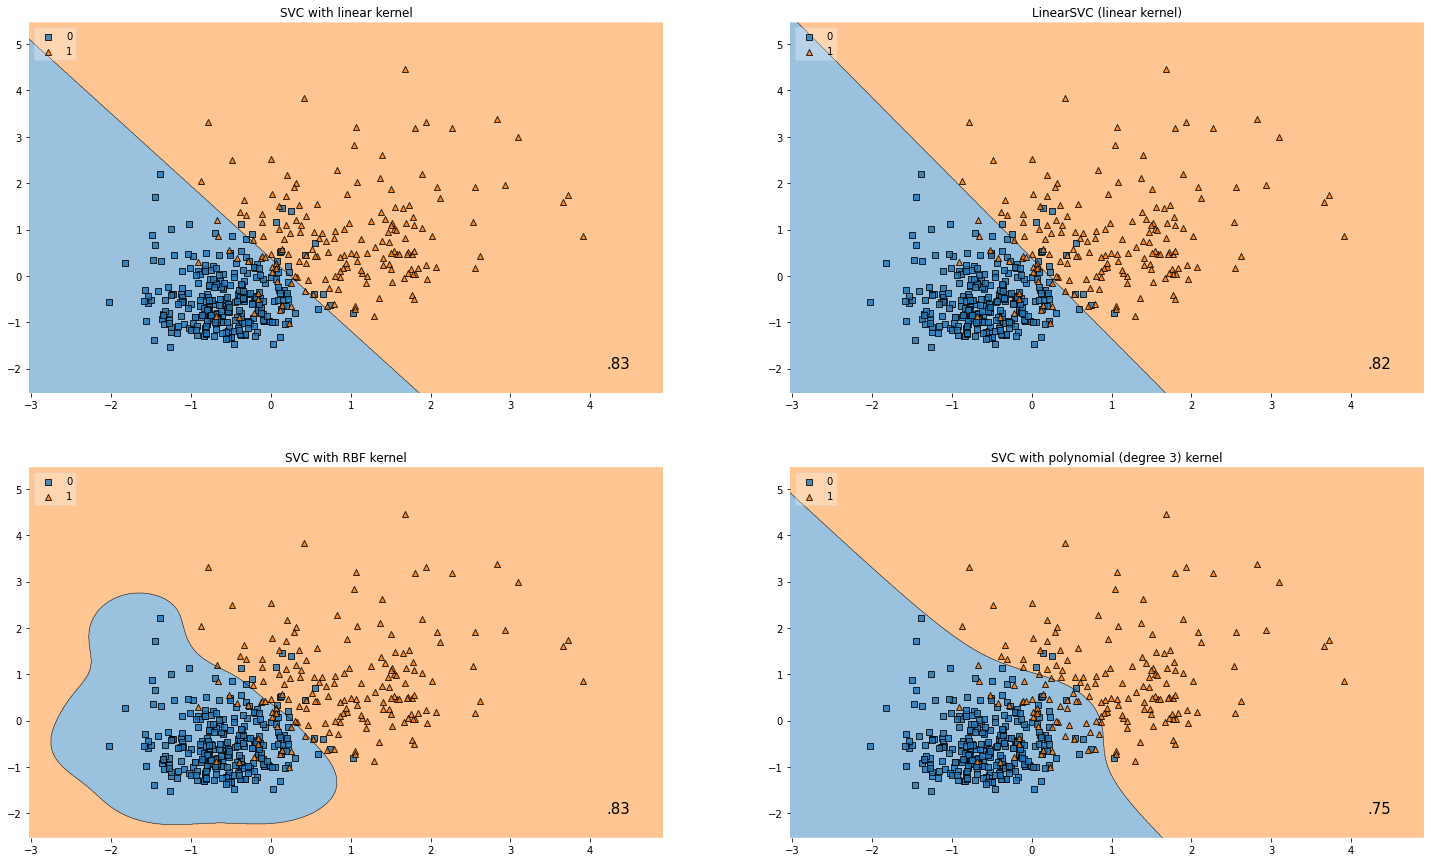

In [26]:

h = .02  # step size in the mesh

Xtrain, ytrain = X_train_sel_pca2.values, y_train
Xtest, ytest = X_test_sel_pca2.values, y_test
scalar = StandardScaler()
scalar.fit(Xtrain)
Xtrain = scalar.transform(Xtrain)
Xtest = scalar.transform(Xtest)

C = 1  # SVM regularization parameter
svc = SVC(kernel='linear', C=C).fit(Xtrain, ytrain)
rbf_svc = SVC(kernel='rbf', gamma=2, C=C).fit(Xtrain, ytrain)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(Xtrain, ytrain)
lin_svc = LinearSVC(C=C).fit(Xtrain, ytrain)

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


fig, axs = plt.subplots(nrows=2, ncols=2,  figsize=(25,15))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    rows = i // 2
    cols = i % 2
    ax = axs[rows,cols]
    ax.set_title(titles[i])
    
    score = f1_score(ytest, clf.predict(Xtest))
    
    ax.text(
    4.5,
    -2,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right")
    
    plot_decision_regions(Xtrain, ytrain, clf=clf, legend=2, ax=ax)
    
plt.show()


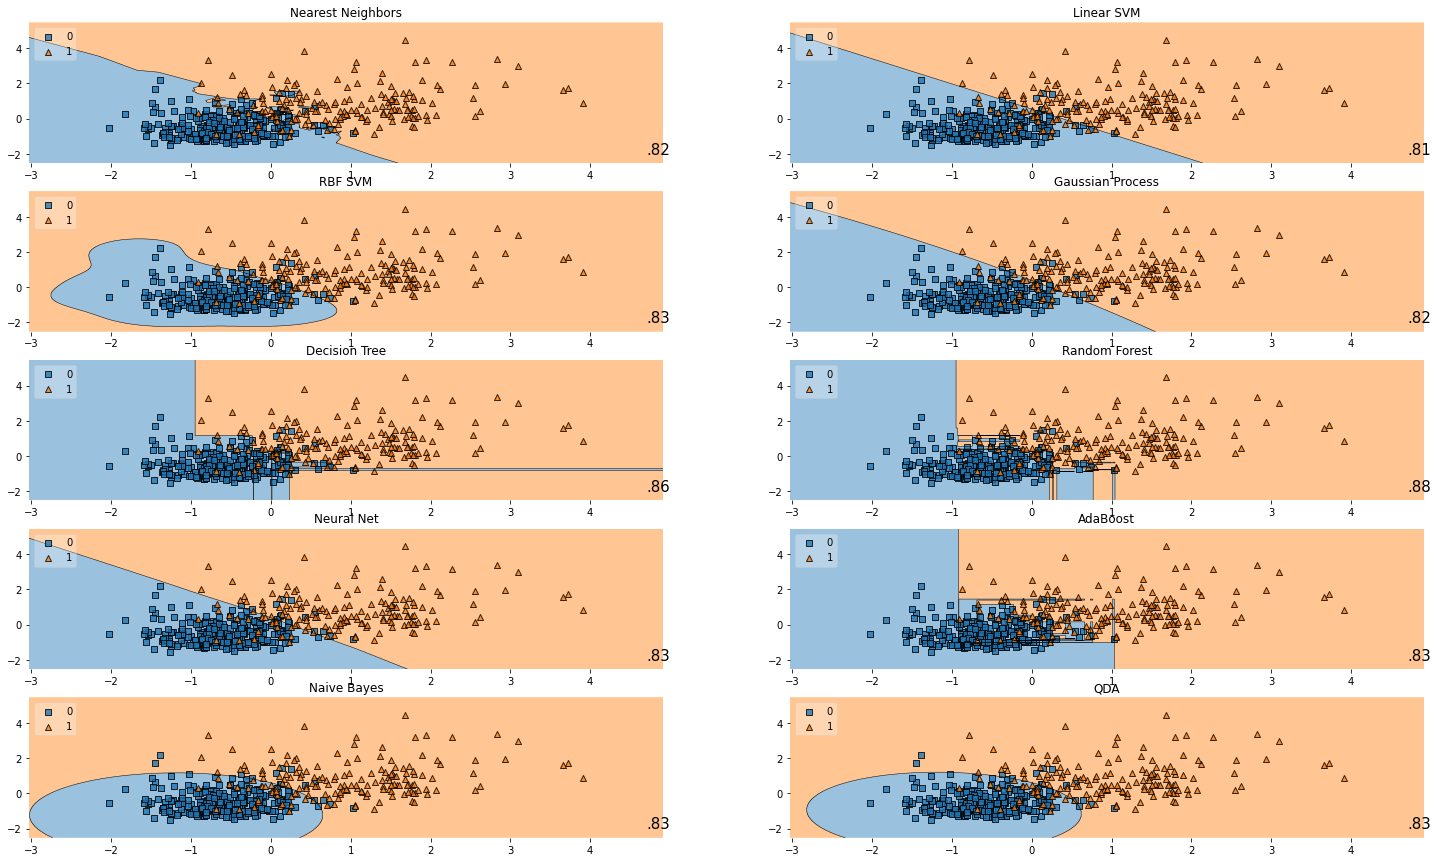

In [27]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

Xtrain, ytrain = X_train_sel_pca2.values, y_train
Xtest, ytest = X_test_sel_pca2.values, y_test
scalar = StandardScaler()
scalar.fit(Xtrain)
Xtrain = scalar.transform(Xtrain)
Xtest = scalar.transform(Xtest)

fig, axs = plt.subplots(nrows=5, ncols=2,  figsize=(25,15))

i = 0
# iterate over classifiers
for name, clf in zip(names, classifiers):
    rows = i // 2
    cols = i % 2
    ax = axs[rows,cols]
    ax.set_title(name)
        
    clf.fit(Xtrain, ytrain)
    #score = clf.score(Xtest, ytest)
    score = f1_score(ytest, clf.predict(Xtest))
    
    ax.text(
    5,
    -2,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right")
    
    plot_decision_regions(Xtrain, ytrain, clf=clf, legend=2, ax=ax)
    i +=1  
plt.show()

